In [44]:
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
from MLP import MLP
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
from KAN import KANWrapper
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare data

In [ ]:
# get input data
deepmimo = True

function_folder = "seq_sin_gaussian_12.15"

data = CreateInput(function_folder, deepmimo)

tensors = data.get_tensors()

             0          1          2          3          4          5  \
0   -19.093129  -7.301641  24.608357 -20.160930  15.963657 -55.402594   
1     7.647578 -16.616755  -2.251510  16.815834  -0.152914  18.964095   
2    -9.092224  12.501910  12.442066  -7.356900  -0.621661   1.482643   
3   -32.925429  31.103686   9.979712  16.911249  -1.026798  22.716388   
4   -28.368509  23.086171 -36.876031 -24.540936  15.778087   1.051396   
..         ...        ...        ...        ...        ...        ...   
695 -13.810964 -14.454104 -29.183735   8.197944 -34.617559 -10.944768   
696  23.962716  17.825274 -31.726385  18.783043   5.272100 -13.645007   
697   4.954854  -9.480472  -4.363124  -8.321417 -28.563159   0.758961   
698  -4.926822  20.538168   4.889502 -21.028875   7.146303 -18.201595   
699 -29.404866  -4.104433 -17.649342  -4.302955  23.307609  13.447380   

             6          7          8          9  ...         20         21  \
0    -4.481762   7.805075   0.472126  55.1601

In [46]:
print(type(data))

<class 'convert_data_to_input.CreateInput'>


In [47]:
tensors['test'][1].shape

torch.Size([200, 30])

# Evaluate KAN

In [48]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors,deepmimo=deepmimo)
input_size = tensors['test'][1].shape[1]

if deepmimo:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[input_size, 2*input_size + 1, input_size],
                       [input_size, 20, input_size], [input_size, 20, 20, input_size], [input_size, 20, 20, 20, input_size],
                       [input_size, 10, input_size],
                       [input_size, 5, input_size],
                       [input_size, 20, 10, 20, input_size], [input_size, 10, 5, 10, input_size]], 
        'kan__grid': [3, 5],
        'kan__k': [3, 5],
        'kan__seed': [42],
        'kan__lr': [0.01],
        'kan__lamb': [0],
        'kan__deepmimo': [True],
        'kan__epochs': [10]
    }

else:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1, 3, 1], [1, 3, 3, 1], [1, 3, 3, 3, 1], [1, 3, 1], [1, 5, 5, 1], [1, 5, 5, 5, 1], [1, 7, 1], [1, 7, 7, 1], [1, 7, 7, 7, 1]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001, 0.0001],
        'kan__lamb': [0],
        'kan__deepmimo': [False],
        'kan__epochs': [20]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=1
)"""
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=1
)
# Fit RandomizedSearchCV
grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['kan__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_KAN = grid_search.best_params_


Fitting 5 folds for each of 32 candidates, totalling 160 fits


| train_loss: 3.10e-03 | test_loss: 1.02e+00 | reg: 2.97e+01 | : 100%|█| 10/10 [00:11<00:00,  1.15s/
| train_loss: 2.35e-03 | test_loss: 9.98e-01 | reg: 2.86e+01 | : 100%|█| 10/10 [00:12<00:00,  1.22s/
| train_loss: 2.60e-03 | test_loss: 9.44e-01 | reg: 2.90e+01 | : 100%|█| 10/10 [00:12<00:00,  1.27s/
| train_loss: 2.79e-03 | test_loss: 1.09e+00 | reg: 2.93e+01 | : 100%|█| 10/10 [00:12<00:00,  1.29s/
| train_loss: 2.81e-03 | test_loss: 1.05e+00 | reg: 2.92e+01 | : 100%|█| 10/10 [00:13<00:00,  1.33s/
| train_loss: 1.75e-03 | test_loss: 1.02e+00 | reg: 6.73e+01 | : 100%|█| 10/10 [00:16<00:00,  1.65s/
| train_loss: 1.81e-03 | test_loss: 1.04e+00 | reg: 6.86e+01 | : 100%|█| 10/10 [00:17<00:00,  1.77s/
| train_loss: 1.82e-03 | test_loss: 1.07e+00 | reg: 6.95e+01 | : 100%|█| 10/10 [00:15<00:00,  1.58s/
| train_loss: 1.69e-03 | test_loss: 1.08e+00 | reg: 6.88e+01 | : 100%|█| 10/10 [00:16<00:00,  1.62s/
| train_loss: 8.90e-03 | test_loss: 1.08e+00 | reg: 9.53e+01 | : 100%|█| 10/10 [00:29<00:00

Best Parameters: {'kan__data': [], 'kan__deepmimo': True, 'kan__epochs': 10, 'kan__grid': 3, 'kan__k': 3, 'kan__lamb': 0, 'kan__lr': 0.01, 'kan__seed': 42, 'kan__width': [[30, 0], [20, 0], [20, 0], [20, 0], [30, 0]]}
Best Cross-Validation Score: -2.451018681313144e-05


In [49]:
# evaluate KAN with optimal params
kan_model = KANModel(width=opt_params_KAN['kan__width'], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'], deepmimo=deepmimo, epochs=30, results_path=f'results/KAN/{function_folder}')
kan_model.load_data(tensors)
loss_data, time_elapsed = kan_model.fit()
y_preds = kan_model.predict()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.48e-04 | test_loss: 2.83e-03 | reg: 6.19e+01 | : 100%|█| 30/30 [00:20<00:00,  1.49it

saving model version 0.1


In [50]:
"""print(y_preds['preds'][0].shape)
x=np.linspace(-10, 10, 20)
many_x = np.linspace(-10, 10, 200)
plt.plot(x, y_preds['preds'][0], "o")
plt.plot(many_x, np.sin(many_x))
plt.plot(x, tensors['train'][0][0], ".")
plt.show()"""

'print(y_preds[\'preds\'][0].shape)\nx=np.linspace(-10, 10, 20)\nmany_x = np.linspace(-10, 10, 200)\nplt.plot(x, y_preds[\'preds\'][0], "o")\nplt.plot(many_x, np.sin(many_x))\nplt.plot(x, tensors[\'train\'][0][0], ".")\nplt.show()'

In [51]:
"""if deepmimo:
    kan_model = KANModel(width=[20, 10,10, 20], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()"""

'if deepmimo:\n    kan_model = KANModel(width=[20, 10,10, 20], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)\n    kan_model.load_data(tensors)\n    loss_data, time_elapsed = kan_model.fit()\n    y_preds = kan_model.predict()'

torch.Size([30])
30


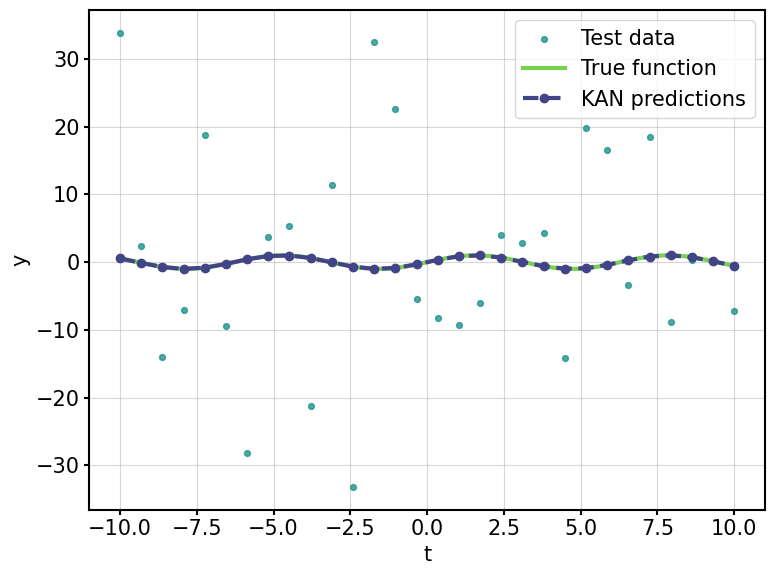

In [52]:
# plot pred and true
if deepmimo:
    #kan_model.plot_deepmimo(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)
    kan_model.plot_sequence(data=tensors, y_preds=y_preds['preds'], type_='test', save=True)
else:
    kan_model.plot_prediction(data=tensors, y_preds=y_preds['preds'], type_='test', save=True)

In [53]:
# plot noise and true
# if deepmimo:
#     kan_model.plot_deepmimo(data=tensors, y_preds=tensors['test'][0][:2,:], type_='test', save=False)

In [54]:
# diffrence in noise and true
#torch.sum(np.abs(tensors['test'][0][:1,:] - tensors['test'][1][:1,:]))

In [55]:
# diffrence pred and true
#torch.sum(np.abs(y_preds['preds'][0] - tensors['test'][1][:1,:]))

saved loss to  results/KAN/seq_sin_gaussian_-29.26/loss.png
Model parameters saved to results/KAN/seq_sin_gaussian_-29.26/model_params.txt


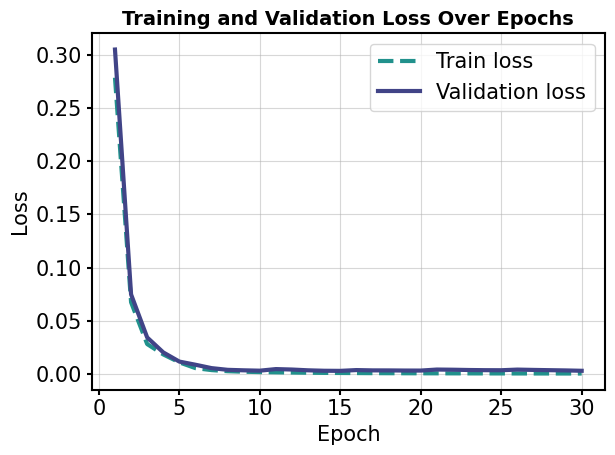

In [56]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=True)

In [57]:
# Test loss
print(y_preds['test_loss'])

tensor(0.0017)


# Evaluate MLP

In [58]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [input_size],
        'mlp__hidden_size': [[2*input_size + 1],
                       [20], [20, 20], [20, 20, 20],
                       [10],
                       [5],
                       [20, 10, 20], [10, 5, 10]],
        'mlp__output_size': [input_size],
        'mlp__epochs': [10],
        'mlp__deepmimo': [True],
        'mlp__lr': [0.01]
    }

else:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1],
        'mlp__hidden_size': [[3], [3, 3], [3, 3, 3], [5], [5, 5], [5, 5, 5], [7], [7, 7], [7, 7, 7]],
        'mlp__output_size': [1],
        'mlp__epochs': [20, 21],
        'mlp__deepmimo': [False],
        'mlp__lr': [0.001]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)"""

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=1
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['mlp__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/zeshenbao/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/10 [00:00<?, ?it/s]/Users/zeshenbao/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/10 [00:00<?, ?it/s]/Users/zeshenbao/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/10 [00:00<?, ?

Best Parameters: {'mlp__data': [], 'mlp__deepmimo': True, 'mlp__epochs': 10, 'mlp__hidden_size': [10], 'mlp__input_size': 30, 'mlp__lr': 0.01, 'mlp__output_size': 30}
Best Cross-Validation Score: -8.175271113941563e-06


In [59]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'], result_path=f'results/MLP/{function_folder}')
mlp_model.load_data(tensors, deepmimo=deepmimo)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=30, cross_validation=False, deepmimo=deepmimo)
y_preds_MLP = mlp_model.predict(mlp_model.X_test,eval=True)

100%|██████████| 30/30 [00:00<00:00, 53.86it/s]


torch.Size([30])
30


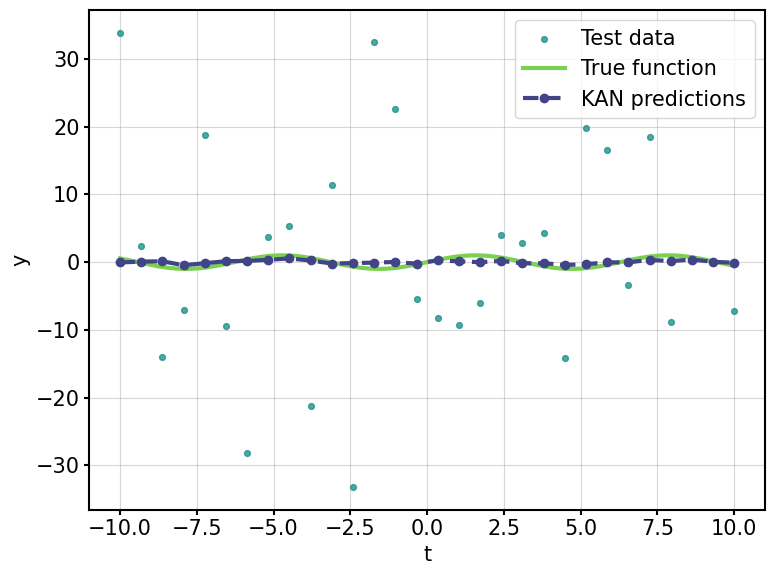

In [60]:
# plot predictions
if deepmimo:
    # mlp_model.plot_deepmimo(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)
    mlp_model.plot_sequence(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=True)
else:
    mlp_model.plot_prediction(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=True)

saved loss to  results/MLP/seq_sin_gaussian_-29.26/loss.png
Model parameters saved to results/MLP/seq_sin_gaussian_-29.26/model_params.txt


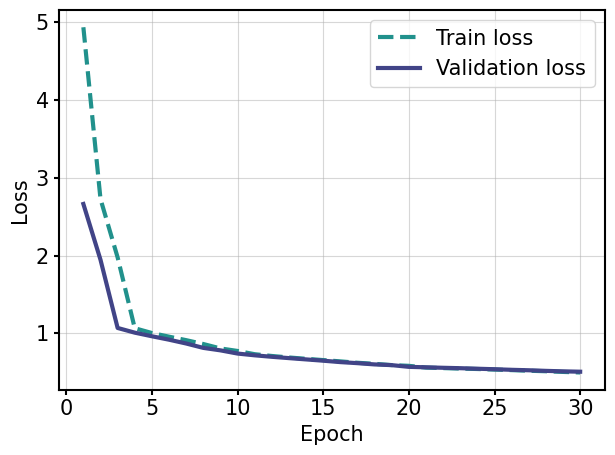

In [61]:
# plot loss

mlp_model.plot_loss(loss_data=loss_data_MLP, save=True, deepmimo=deepmimo)

In [62]:
# Test loss
print(y_preds_MLP['test_loss'])

tensor(0.4924)
